# Face Recognition model with Adaptive Noise Label Canceling

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain
from FaceRecognitionModel import FaceRecognitionRNN

### Load Dataset

In [3]:
# Custom dataset class
class LFWDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

lfw_path = r'C:\Users\Anvesha\Documents\Assignments\AWS\Implementation\lfw_data\aug'
input_size = 4096  # Adjusted for 64x64 grayscale image flattened

# Loading function
def load_lfw_data():
    X, y = [], []
    for person_dir in os.listdir(lfw_path):
        person_path = os.path.join(lfw_path, person_dir)
        for image_file in os.listdir(person_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(person_path, image_file)
                image = Image.open(image_path).convert('L').resize((64, 64))
                X.append(np.array(image).flatten())
                y.append(person_dir)
    return np.array(X), np.array(y)

# Load the data
X, y = load_lfw_data()


### Label Encoding

In [4]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

### Split the dataset

In [5]:
# Split the data while maintaining class distribution
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

## Loss Distribution

In [6]:
def detect_noisy_labels(X, y, num_epochs=5, batch_size=32):
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    # Create a DataLoader for the dataset
    dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Set the loss function and optimizer
    hidden_size = 256
    num_layers = 1
    num_classes = len(np.unique(y_encoded))
    model = FaceRecognitionRNN(input_size, hidden_size, num_layers, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_classes = len(np.unique(y_encoded))
    # Train the model on the input data
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        for images, labels in data_loader:
            images, labels = images.view(images.size(0), -1, input_size), labels  # Reshape for LSTM

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate the loss for each training sample
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Calculate the losses
        losses = []
        for images, labels in data_loader:
            images = images.view(images.size(0), -1, input_size)  # Reshape for LSTM
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    # Convert losses to a numpy array
    losses = np.array(losses)

    # Compute the mean and standard deviation of the loss distribution
    loss_mean = np.mean(losses)
    loss_std = np.std(losses)

    # Define the threshold for identifying noisy labels
    threshold = loss_mean + 2 * loss_std

    # Identify noisy samples based on the threshold
    noisy_indices = np.where(losses > threshold)[0]

    # Create the cleaned training set
    X_cleaned = np.delete(X, noisy_indices, axis=0)
    y_cleaned = np.delete(y, noisy_indices)

    return X_cleaned, y_cleaned

In [7]:
# Detect and clean noisy labels
X_train_denoised, y_train_denoised = detect_noisy_labels(X_train, y_train)


In [10]:
# Map labels 
unique_classes = np.unique(y_train_denoised)
if unique_classes[0] != 0 or len(unique_classes) != (unique_classes[-1] + 1):
    label_map = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}
    y_train_cleaned = np.array([label_map[label] for label in y_train_denoised])

In [11]:
# Prepare cleaned data
class LFWDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and dataloader
train_dataset = LFWDataset(X_train_denoised, y_train_denoised)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [13]:
# Initialize the model
input_size = 4096  
num_classes = len(np.unique(y_train_denoised))
hidden_size = 256  
num_layers = 2
model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Save the model weights
torch.save(model.state_dict(), 'loss_distribution.pth')
print("Model weights saved as 'loss_distribution.pth'")

Epoch [1/1], Loss: 8.3350
Model weights saved as 'loss_distribution.pth'


## Evaluation with Explainable AI

### SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations)

In [ ]:
import shap
import lime
import lime.lime_tabular

class ModelWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict_proba(self, X):
        X = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            probas = torch.softmax(outputs, dim=1)
        return probas.numpy()

def analyze_interpretability(model, X, feature_names=None, 
                           use_sample=True, n_background=100, 
                           n_test_samples=5,
                           lime_samples=1):
    
    print("Starting interpretability analysis...")
    
    # Initialize feature names if not provided
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    
    # Prepare data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Wrap model
    model_wrapper = ModelWrapper(model)
    
    # SHAP Analysis
    print("\nPerforming SHAP analysis...")
    if use_sample:
        print(f"Using {n_background} background samples...")
        background_data = shap.kmeans(X_scaled, n_background)
    else:
        print("Using full dataset as background...")
        background_data = X_scaled
    
    explainer = shap.KernelExplainer(model_wrapper.predict_proba, background_data)
    
    # Calculate SHAP values
    test_samples = X_scaled[:n_test_samples]
    shap_values = explainer.shap_values(test_samples)
    
    # LIME Analysis
    print("\nPerforming LIME analysis...")
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_scaled,
        feature_names=feature_names,
        class_names=[f"Class_{i}" for i in range(model.fc.out_features)],
        mode="classification"
    )
    
    lime_explanations = []
    for i in range(lime_samples):
        print(f"Generating LIME explanation for sample {i+1}/{lime_samples}")
        exp = lime_explainer.explain_instance(
            X_scaled[i],
            model_wrapper.predict_proba,
            num_features=10
        )
        lime_explanations.append(exp)
    
    results = {
        'shap_values': shap_values,
        'shap_test_samples': test_samples,
        'lime_explanations': lime_explanations,
        'feature_names': feature_names,
        'background_size': background_data.shape[0]
    }
    
    print("\nAnalysis completed!")
    print(f"SHAP values shape: {[sv.shape for sv in shap_values]}")
    print(f"Number of LIME explanations: {len(lime_explanations)}")
    
    return results

def analyze_both_datasets(model, X_original, X_cleaned, feature_names=None, 
                         use_sample=True, n_background=100, 
                         n_test_samples=5, lime_samples=1):
    print("Starting comparative analysis...")
    
    # Analyze original data
    print("\n=== Analyzing Original Data ===")
    original_results = analyze_interpretability(
        model=model,
        X=X_original,
        feature_names=feature_names,
        use_sample=use_sample,
        n_background=n_background,
        n_test_samples=n_test_samples,
        lime_samples=lime_samples
    )
    
    # Analyze cleaned data
    print("\n=== Analyzing Cleaned Data ===")
    cleaned_results = analyze_interpretability(
        model=model,
        X=X_cleaned,
        feature_names=feature_names,
        use_sample=use_sample,
        n_background=n_background,
        n_test_samples=n_test_samples,
        lime_samples=lime_samples
    )
    
    return {
        'original': original_results,
        'cleaned': cleaned_results
    }

def plot_interpretability_results(results):
    """
    Plot SHAP and LIME results
    """
    # Plot SHAP summary
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        results['shap_values'], 
        results['shap_test_samples'],
        feature_names=results['feature_names'],
        show=False
    )
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Plot LIME explanations
    for i, exp in enumerate(results['lime_explanations']):
        plt.figure(figsize=(10, 6))
        exp.as_pyplot_figure()
        plt.title(f"LIME Explanation for Instance {i+1}")
        plt.tight_layout()
        plt.show()

In [ ]:
# Then run the analysis
results = analyze_both_datasets(
    model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes),
    X_original=X_train,
    X_cleaned=X_train_denoised,
    use_sample=True,
    n_background=10,
    n_test_samples=5,
    lime_samples=1
)

# # For full dataset analysis:
# results = analyze_both_datasets(
#     model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes),
#     X_original=X_train,
#     X_cleaned=X_train_denoised,
#     use_sample=False,
#     n_test_samples=20,
#     lime_samples=5
# )

# Plot results for both datasets
print("\nPlotting Original Data Results:")
plot_interpretability_results(results['original'])

print("\nPlotting Cleaned Data Results:")
plot_interpretability_results(results['cleaned'])

### S-RISE (Saliency-guided Random Input Sampling for Explanation)

In [ ]:
class SRISE:
    def __init__(self, model, input_size, n_samples=1000, s=8, p1=0.5, sigma=2.0):
        """
        Initialize S-RISE.
        
        Args:
            model: The model to explain
            input_size: Size of input features
            n_samples: Number of mask samples
            s: Stride size
            p1: Base probability
            sigma: Gaussian smoothing parameter
        """
        self.model = model
        # Convert input_size to 2D if it's 1D
        if isinstance(input_size, int):
            self.height = int(np.sqrt(input_size))
            self.width = self.height
            if self.height * self.width != input_size:
                raise ValueError(f"Input size {input_size} must be a perfect square for 2D reshaping")
        else:
            self.height, self.width = input_size
            
        self.n_samples = n_samples
        self.s = s
        self.p1 = p1
        self.sigma = sigma
        self.device = next(model.parameters()).device
        self.masks = self.generate_masks()
        
    def gaussian_kernel(self, sigma):
        """Generate Gaussian kernel."""
        kernel_size = int(4 * sigma + 1)
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        center = kernel_size // 2
        x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
        kernel = np.exp(-((x - center) ** 2 + (y - center) ** 2) / (2 * sigma ** 2))
        kernel = kernel / kernel.sum()
        
        return torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
    
    def gaussian_blur(self, x, sigma):
        """Apply Gaussian blur to tensor."""
        kernel = self.gaussian_kernel(sigma)
        kernel = kernel.to(x.device)
        channels = x.shape[1]
        
        # Ensure kernel size is smaller than input dimensions
        if kernel.shape[-1] >= min(x.shape[-2:]):
            kernel = self.gaussian_kernel(sigma/2)  # Use smaller kernel
            
        padding = kernel.shape[-1]//2
        x_padded = torch.nn.functional.pad(x, (padding, padding, padding, padding), mode='reflect')
        return torch.nn.functional.conv2d(x_padded, kernel, groups=channels)
    
    def generate_masks(self):
        """Generate random masks."""
        masks = []
        for _ in range(self.n_samples):
            # Generate 2D mask
            h = int(np.ceil(self.height/self.s))
            w = int(np.ceil(self.width/self.s))
            mask = np.random.choice([0, 1], size=(h, w), p=[1-self.p1, self.p1])
            
            # Upsample to full size
            mask = torch.FloatTensor(mask)
            mask = nn.functional.interpolate(
                mask.unsqueeze(0).unsqueeze(0),
                size=(self.height, self.width),
                mode='nearest'
            )
            
            # Apply Gaussian smoothing
            mask = self.gaussian_blur(mask, self.sigma).squeeze()
            masks.append(mask)
            
        return torch.stack(masks).to(self.device)
    
    def explain(self, x, batch_size=32):
        """Generate saliency map for input x."""
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)

        # Convert the tensor to float32
        x = x.float() 

        if len(x.shape) == 1:
            # Reshape 1D input to 2D
            x = x.unsqueeze(0).unsqueeze(0).view(1, 1, self.height, self.width)
        elif len(x.shape) == 2:
            # If it's already 2D, add the batch and channel dimensions
            x = x.unsqueeze(0).unsqueeze(0)  # Shape becomes (1, 1, height, width)
        elif len(x.shape) == 3:
            # If it's 3D, assume the input shape is (channels, height, width)
            x = x.unsqueeze(0)  # Add batch dimension

        self.model.eval()
        predictions = []
        
        with torch.no_grad():
            # Get original prediction
            original_pred = self.model(x)
            pred_class = original_pred.argmax().item()
            
            # Process masks in batches
            for i in range(0, self.n_samples, batch_size):
                batch_masks = self.masks[i:i+batch_size]
                batch_size = len(batch_masks)
                
                # Apply masks
                masked_inputs = x.repeat(batch_size, 1, 1, 1) * batch_masks.unsqueeze(1)
                batch_preds = self.model(masked_inputs.view(batch_size, -1))
                predictions.append(batch_preds[:, pred_class])
                
        # Calculate saliency map
        predictions = torch.cat(predictions)
        saliency_map = torch.zeros(self.height * self.width, dtype=torch.float32)
        
        for i, pred in enumerate(predictions):
            saliency_map += pred * self.masks[i].view(-1)
            
        return saliency_map.view(self.height, self.width)
    
    def visualize(self, x, saliency_map, save_path):
        """Visualize original input and saliency map."""
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Original Input')
        
        # Check if x is a tensor and print its shape
        if isinstance(x, torch.Tensor):
            # Ensure x is reshaped and moved to CPU before converting to NumPy
            if len(x.shape) == 1:
                x = x.view(1, -1)  # Ensure it's at least 2D
            original_input = x.view(self.height, self.width).cpu().detach().numpy()
        else:
            raise ValueError("Input x must be a torch.Tensor")
        
        plt.imshow(original_input, cmap='gray')
        plt.axis('off')

        # Plot saliency map
        plt.subplot(1, 2, 2)
        plt.title('Saliency Map')
        
        # Ensure saliency_map is moved to CPU before converting to NumPy
        if isinstance(saliency_map, torch.Tensor):
            saliency_map_cpu = saliency_map.cpu().detach().numpy()
        else:
            raise ValueError("Saliency map must be a torch.Tensor")

        plt.imshow(saliency_map_cpu, cmap='hot')
        plt.axis('off')

        plt.savefig(save_path)
        plt.show()

def compare_srise_explanations(model, X_original, X_cleaned, n_samples=3):
    """Compare SRISE explanations for original and cleaned data."""
    input_size = X_original.shape[1]
    srise = SRISE(model, input_size)
    
    plt.figure(figsize=(12, 4*n_samples))
    for i in range(n_samples):
        # Original data
        smap_original = srise.explain(X_original[i])
        plt.subplot(n_samples, 2, 2*i + 1)
        plt.title(f'Original Data - Sample {i+1}')
        plt.imshow(smap_original.cpu().numpy(), cmap='hot')
        plt.colorbar()
        plt.axis('off')
        
        # Cleaned data
        smap_cleaned = srise.explain(X_cleaned[i])
        plt.subplot(n_samples, 2, 2*i + 2)
        plt.title(f'Cleaned Data - Sample {i+1}')
        plt.imshow(smap_cleaned.cpu().numpy(), cmap='hot')
        plt.colorbar()
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize S-RISE with your model
srise = SRISE(
    model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes),
    input_size=4096,  # Will be automatically reshaped to (64, 64)
    n_samples=1000,
    s=8,
    p1=0.5,
    sigma=2.0
)

# Generate saliency map for a sample
sample = X_train[0]

# Convert ndarray to PyTorch tensor
if isinstance(sample, np.ndarray):
    sample = torch.tensor(sample)

# Ensure the tensor is of type float32
sample = sample.float()
    
saliency_map = srise.explain(sample, batch_size=32)

# Visualize results
srise.visualize(sample, saliency_map, save_path='srise_visualization.png')

In [ ]:
# Compare original and cleaned data
def compare_srise_explanations(model, X_original, X_cleaned, n_samples=3):
    srise = SRISE(model, X_original.shape[1])
    
    for i in range(n_samples):
        # Original data
        original = X_original[i]
        smap_original = srise.explain(original)
        print(f"\nOriginal Data - Sample {i+1}:")
        if isinstance(original, np.ndarray):
            original = torch.tensor(original)
        original = original.float()
        srise.visualize(original, smap_original, save_path='srise_visualization_original.png')
        
        # Cleaned data
        cleaned =  X_cleaned[i]
        smap_cleaned = srise.explain(cleaned)
        print(f"\nCleaned Data - Sample {i+1}:")
        if isinstance(cleaned, np.ndarray):
            cleaned = torch.tensor(cleaned)
        cleaned = cleaned.float()
        srise.visualize(cleaned, smap_cleaned, save_path='srise_visualization_cleaned.png')
        
# Run comparison
compare_srise_explanations(
    model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes),
    X_original=X_train,
    X_cleaned=X_train_denoised,
    n_samples=3
)

## Co-Teaching

In [28]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pth'):  # Change to .pth
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.acc_list = []

    def __call__(self, val_loss, model, test_acc):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)  # Save the initial model
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.acc_list.append(test_acc)
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)  # Save the new best model
            self.counter = 0
            self.acc_list.clear()

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)  # Save as .pth file
        self.val_loss_min = val_loss
        
class LFWDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def co_teaching_loss(model1_loss, model2_loss, rt):
    """Implementation of co-teaching loss"""
    _, model1_sm_idx = torch.topk(model1_loss, k=int(int(model1_loss.size(0)) * rt), largest=False)
    _, model2_sm_idx = torch.topk(model2_loss, k=int(int(model2_loss.size(0)) * rt), largest=False)

    model1_loss_filter = torch.zeros((model1_loss.size(0))).to(model1_loss.device)
    model1_loss_filter[model2_sm_idx] = 1.0
    model1_loss = (model1_loss_filter * model1_loss).sum()

    model2_loss_filter = torch.zeros((model2_loss.size(0))).to(model2_loss.device)
    model2_loss_filter[model1_sm_idx] = 1.0
    model2_loss = (model2_loss_filter * model2_loss).sum()

    return model1_loss, model2_loss

def update_reduce_step(current_step, num_gradual, tau=0.5):
    """Update the reduction rate during training"""
    return 1.0 - tau * min(current_step / num_gradual, 1)

def validate_model(model, val_loader, criterion, device):
    """Validation step"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    return total_loss / len(val_loader), correct / total

def train_coteaching_no_noise(model1, model2, train_loader, val_loader, test_loader, 
                              num_epochs=100, lr=0.001, num_gradual=10, tau=0.5, 
                              patience=7, device="cuda"):
    
    optimizer = optim.Adam(chain(model1.parameters(), model2.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction='none')  # For per-sample losses
    criterion_val = nn.CrossEntropyLoss()  # For validation (mean reduction)
    
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='co_teaching.pth')  
    
    train_acc_list = []
    test_acc_list = []
    
    model1 = model1.to(device)
    model2 = model2.to(device)
    
    for epoch in range(num_epochs):
        rt = update_reduce_step(current_step=epoch, num_gradual=num_gradual, tau=tau)
        
        model1.train()
        model2.train()
        train_acc = 0
        train_total = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            # Forward pass with all data (no noise filtering)
            out1 = model1(x)
            out2 = model2(x)

            model1_loss = criterion(out1, y)
            model2_loss = criterion(out2, y)
            
            model1_loss, model2_loss = co_teaching_loss(
                model1_loss=model1_loss,
                model2_loss=model2_loss,
                rt=rt
            )

            optimizer.zero_grad()
            model1_loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            model2_loss.backward()
            optimizer.step()
            
            _, pred1 = torch.max(out1.data, 1)
            train_acc += (pred1 == y).sum().item()
            train_total += y.size(0)
        
        train_accuracy = train_acc / train_total
        val_loss, val_acc = validate_model(model1, val_loader, criterion_val, device)
        
        model1.eval()
        test_acc = 0
        test_total = 0
        
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model1(x)
                _, predicted = torch.max(outputs.data, 1)
                test_total += y.size(0)
                test_acc += (predicted == y).sum().item()
        
        test_accuracy = test_acc / test_total
        early_stopping(val_loss, model1, test_accuracy)
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
              f'Test Acc: {test_accuracy:.4f}, Reduce Rate: {rt:.4f}')
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    model1.load_state_dict(torch.load('co_teaching.pth'))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(test_acc_list, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()
    
    return model1, model2

def train_lfw_without_noise(X_train, y_train, X_val, y_val, X_test, y_test,
                            input_size, hidden_size, num_layers, num_classes):
    train_dataset = LFWDataset(X_train, y_train)
    val_dataset = LFWDataset(X_val, y_val)
    test_dataset = LFWDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model1 = FaceRecognitionRNN(input_size, hidden_size, num_layers, num_classes)
    model2 = FaceRecognitionRNN(input_size, hidden_size, num_layers, num_classes)
    
    trained_model1, trained_model2 = train_coteaching_no_noise(
        model1=model1,
        model2=model2,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=5,
        lr=0.001,
        num_gradual=10,
        tau=0.5,
        patience=7,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    
    return trained_model1, trained_model2

Validation loss decreased (inf --> 8.320193). Saving model ...
Epoch [1/5], Train Acc: 0.0004, Val Loss: 8.3202, Val Acc: 0.0002, Test Acc: 0.0002, Reduce Rate: 1.0000
Validation loss decreased (8.320193 --> 8.097259). Saving model ...
Epoch [2/5], Train Acc: 0.0002, Val Loss: 8.0973, Val Acc: 0.0002, Test Acc: 0.0010, Reduce Rate: 0.9500
Validation loss decreased (8.097259 --> 7.808554). Saving model ...
Epoch [3/5], Train Acc: 0.0003, Val Loss: 7.8086, Val Acc: 0.0020, Test Acc: 0.0015, Reduce Rate: 0.9000
Validation loss decreased (7.808554 --> 7.582337). Saving model ...
Epoch [4/5], Train Acc: 0.0009, Val Loss: 7.5823, Val Acc: 0.0039, Test Acc: 0.0029, Reduce Rate: 0.8500
Validation loss decreased (7.582337 --> 7.409552). Saving model ...
Epoch [5/5], Train Acc: 0.0021, Val Loss: 7.4096, Val Acc: 0.0054, Test Acc: 0.0061, Reduce Rate: 0.8000


C:\Users\Anvesha\AppData\Local\Temp\ipykernel_25540\2270260355.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('co_teaching.pth'))


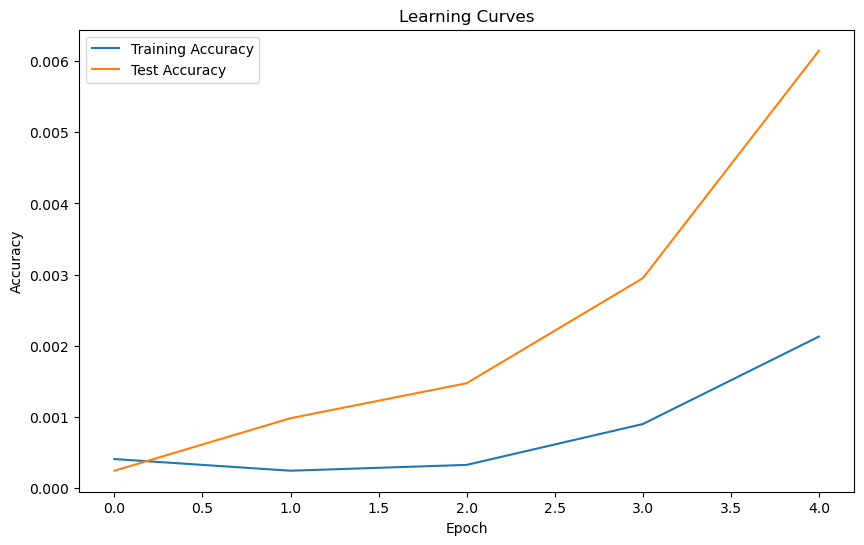

In [29]:
# Model parameters
input_size = 128  # Size of each input sample
hidden_size = 64  # Number of hidden units
num_layers = 2    # Number of layers in RNN
num_classes = len(np.unique(y_train))

# Train the model using co-teaching
trained_model1, trained_model2 = train_lfw_without_noise(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    input_size, hidden_size, num_layers, num_classes
)

## Evaluation with Explainable AI

### SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations)

In [ ]:
import shap
import lime
import lime.lime_tabular

class ModelWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict_proba(self, X):
        X = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            probas = torch.softmax(outputs, dim=1)
        return probas.numpy()

def analyze_interpretability(model, X, feature_names=None, 
                           use_sample=True, n_background=100, 
                           n_test_samples=5,
                           lime_samples=1):
    
    print("Starting interpretability analysis...")
    
    # Initialize feature names if not provided
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    
    # Prepare data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Wrap model
    model_wrapper = ModelWrapper(model)
    
    # SHAP Analysis
    print("\nPerforming SHAP analysis...")
    if use_sample:
        print(f"Using {n_background} background samples...")
        background_data = shap.kmeans(X_scaled, n_background)
    else:
        print("Using full dataset as background...")
        background_data = X_scaled
    
    explainer = shap.KernelExplainer(model_wrapper.predict_proba, background_data)
    
    # Calculate SHAP values
    test_samples = X_scaled[:n_test_samples]
    shap_values = explainer.shap_values(test_samples)
    
    # LIME Analysis
    print("\nPerforming LIME analysis...")
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_scaled,
        feature_names=feature_names,
        class_names=[f"Class_{i}" for i in range(model.fc.out_features)],
        mode="classification"
    )
    
    lime_explanations = []
    for i in range(lime_samples):
        print(f"Generating LIME explanation for sample {i+1}/{lime_samples}")
        exp = lime_explainer.explain_instance(
            X_scaled[i],
            model_wrapper.predict_proba,
            num_features=10
        )
        lime_explanations.append(exp)
    
    results = {
        'shap_values': shap_values,
        'shap_test_samples': test_samples,
        'lime_explanations': lime_explanations,
        'feature_names': feature_names,
        'background_size': background_data.shape[0]
    }
    
    print("\nAnalysis completed!")
    print(f"SHAP values shape: {[sv.shape for sv in shap_values]}")
    print(f"Number of LIME explanations: {len(lime_explanations)}")
    
    return results

def analyze_both_datasets(model, X_original, X_cleaned, feature_names=None, 
                         use_sample=True, n_background=100, 
                         n_test_samples=5, lime_samples=1):
    print("Starting comparative analysis...")
    
    # Analyze original data
    print("\n=== Analyzing Original Data ===")
    original_results = analyze_interpretability(
        model=model,
        X=X_original,
        feature_names=feature_names,
        use_sample=use_sample,
        n_background=n_background,
        n_test_samples=n_test_samples,
        lime_samples=lime_samples
    )
    
    # Analyze cleaned data
    print("\n=== Analyzing Cleaned Data ===")
    cleaned_results = analyze_interpretability(
        model=model,
        X=X_cleaned,
        feature_names=feature_names,
        use_sample=use_sample,
        n_background=n_background,
        n_test_samples=n_test_samples,
        lime_samples=lime_samples
    )
    
    return {
        'original': original_results,
        'cleaned': cleaned_results
    }

def plot_interpretability_results(results):
    """
    Plot SHAP and LIME results
    """
    # Plot SHAP summary
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        results['shap_values'], 
        results['shap_test_samples'],
        feature_names=results['feature_names'],
        show=False
    )
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Plot LIME explanations
    for i, exp in enumerate(results['lime_explanations']):
        plt.figure(figsize=(10, 6))
        exp.as_pyplot_figure()
        plt.title(f"LIME Explanation for Instance {i+1}")
        plt.tight_layout()
        plt.show()

In [ ]:
# Then run the analysis
results = analyze_both_datasets(
    model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes),
    X_original=X_train,
    X_cleaned=X_train_denoised,
    use_sample=True,
    n_background=10,
    n_test_samples=5,
    lime_samples=1
)

# # For full dataset analysis:
# results = analyze_both_datasets(
#     model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes),
#     X_original=X_train,
#     X_cleaned=X_train_denoised,
#     use_sample=False,
#     n_test_samples=20,
#     lime_samples=5
# )

# Plot results for both datasets
print("\nPlotting Original Data Results:")
plot_interpretability_results(results['original'])

print("\nPlotting Cleaned Data Results:")
plot_interpretability_results(results['cleaned'])

Starting comparative analysis...

=== Analyzing Original Data ===
Starting interpretability analysis...

Performing SHAP analysis...
Using 10 background samples...


KeyboardInterrupt: 

### S-RISE (Saliency-guided Random Input Sampling for Explanation)

In [ ]:
class SRISE:
    def __init__(self, model, input_size, n_samples=1000, s=8, p1=0.5, sigma=2.0):
        """
        Initialize S-RISE.
        
        Args:
            model: The model to explain
            input_size: Size of input features
            n_samples: Number of mask samples
            s: Stride size
            p1: Base probability
            sigma: Gaussian smoothing parameter
        """
        self.model = model
        # Convert input_size to 2D if it's 1D
        if isinstance(input_size, int):
            self.height = int(np.sqrt(input_size))
            self.width = self.height
            if self.height * self.width != input_size:
                raise ValueError(f"Input size {input_size} must be a perfect square for 2D reshaping")
        else:
            self.height, self.width = input_size
            
        self.n_samples = n_samples
        self.s = s
        self.p1 = p1
        self.sigma = sigma
        self.device = next(model.parameters()).device
        self.masks = self.generate_masks()
        
    def gaussian_kernel(self, sigma):
        """Generate Gaussian kernel."""
        kernel_size = int(4 * sigma + 1)
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        center = kernel_size // 2
        x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
        kernel = np.exp(-((x - center) ** 2 + (y - center) ** 2) / (2 * sigma ** 2))
        kernel = kernel / kernel.sum()
        
        return torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
    
    def gaussian_blur(self, x, sigma):
        """Apply Gaussian blur to tensor."""
        kernel = self.gaussian_kernel(sigma)
        kernel = kernel.to(x.device)
        channels = x.shape[1]
        
        # Ensure kernel size is smaller than input dimensions
        if kernel.shape[-1] >= min(x.shape[-2:]):
            kernel = self.gaussian_kernel(sigma/2)  # Use smaller kernel
            
        padding = kernel.shape[-1]//2
        x_padded = torch.nn.functional.pad(x, (padding, padding, padding, padding), mode='reflect')
        return torch.nn.functional.conv2d(x_padded, kernel, groups=channels)
    
    def generate_masks(self):
        """Generate random masks."""
        masks = []
        for _ in range(self.n_samples):
            # Generate 2D mask
            h = int(np.ceil(self.height/self.s))
            w = int(np.ceil(self.width/self.s))
            mask = np.random.choice([0, 1], size=(h, w), p=[1-self.p1, self.p1])
            
            # Upsample to full size
            mask = torch.FloatTensor(mask)
            mask = nn.functional.interpolate(
                mask.unsqueeze(0).unsqueeze(0),
                size=(self.height, self.width),
                mode='nearest'
            )
            
            # Apply Gaussian smoothing
            mask = self.gaussian_blur(mask, self.sigma).squeeze()
            masks.append(mask)
            
        return torch.stack(masks).to(self.device)
    
    def explain(self, x, batch_size=32):
        """Generate saliency map for input x."""
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)

        # Convert the tensor to float32
        x = x.float() 

        if len(x.shape) == 1:
            # Reshape 1D input to 2D
            x = x.unsqueeze(0).unsqueeze(0).view(1, 1, self.height, self.width)
        elif len(x.shape) == 2:
            # If it's already 2D, add the batch and channel dimensions
            x = x.unsqueeze(0).unsqueeze(0)  # Shape becomes (1, 1, height, width)
        elif len(x.shape) == 3:
            # If it's 3D, assume the input shape is (channels, height, width)
            x = x.unsqueeze(0)  # Add batch dimension

        self.model.eval()
        predictions = []
        
        with torch.no_grad():
            # Get original prediction
            original_pred = self.model(x)
            pred_class = original_pred.argmax().item()
            
            # Process masks in batches
            for i in range(0, self.n_samples, batch_size):
                batch_masks = self.masks[i:i+batch_size]
                batch_size = len(batch_masks)
                
                # Apply masks
                masked_inputs = x.repeat(batch_size, 1, 1, 1) * batch_masks.unsqueeze(1)
                batch_preds = self.model(masked_inputs.view(batch_size, -1))
                predictions.append(batch_preds[:, pred_class])
                
        # Calculate saliency map
        predictions = torch.cat(predictions)
        saliency_map = torch.zeros(self.height * self.width, dtype=torch.float32)
        
        for i, pred in enumerate(predictions):
            saliency_map += pred * self.masks[i].view(-1)
            
        return saliency_map.view(self.height, self.width)
    
    def visualize(self, x, saliency_map, save_path):
        """Visualize original input and saliency map."""
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Original Input')
        
        # Check if x is a tensor and print its shape
        if isinstance(x, torch.Tensor):
            # Ensure x is reshaped and moved to CPU before converting to NumPy
            if len(x.shape) == 1:
                x = x.view(1, -1)  # Ensure it's at least 2D
            original_input = x.view(self.height, self.width).cpu().detach().numpy()
        else:
            raise ValueError("Input x must be a torch.Tensor")
        
        plt.imshow(original_input, cmap='gray')
        plt.axis('off')

        # Plot saliency map
        plt.subplot(1, 2, 2)
        plt.title('Saliency Map')
        
        # Ensure saliency_map is moved to CPU before converting to NumPy
        if isinstance(saliency_map, torch.Tensor):
            saliency_map_cpu = saliency_map.cpu().detach().numpy()
        else:
            raise ValueError("Saliency map must be a torch.Tensor")

        plt.imshow(saliency_map_cpu, cmap='hot')
        plt.axis('off')

        plt.savefig(save_path)
        plt.show()

def compare_srise_explanations(model, X_original, X_cleaned, n_samples=3):
    """Compare SRISE explanations for original and cleaned data."""
    input_size = X_original.shape[1]
    srise = SRISE(model, input_size)
    
    plt.figure(figsize=(12, 4*n_samples))
    for i in range(n_samples):
        # Original data
        smap_original = srise.explain(X_original[i])
        plt.subplot(n_samples, 2, 2*i + 1)
        plt.title(f'Original Data - Sample {i+1}')
        plt.imshow(smap_original.cpu().numpy(), cmap='hot')
        plt.colorbar()
        plt.axis('off')
        
        # Cleaned data
        smap_cleaned = srise.explain(X_cleaned[i])
        plt.subplot(n_samples, 2, 2*i + 2)
        plt.title(f'Cleaned Data - Sample {i+1}')
        plt.imshow(smap_cleaned.cpu().numpy(), cmap='hot')
        plt.colorbar()
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize S-RISE with your model
srise = SRISE(
    model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes),
    input_size=4096,  # Will be automatically reshaped to (64, 64)
    n_samples=1000,
    s=8,
    p1=0.5,
    sigma=2.0
)

# Generate saliency map for a sample
sample = X_train[0]

# Convert ndarray to PyTorch tensor
if isinstance(sample, np.ndarray):
    sample = torch.tensor(sample)

# Ensure the tensor is of type float32
sample = sample.float()
    
saliency_map = srise.explain(sample, batch_size=32)

# Visualize results
srise.visualize(sample, saliency_map, save_path='srise_visualization.png')

In [ ]:
# Compare original and cleaned data
def compare_srise_explanations(model, X_original, X_cleaned, n_samples=3):
    srise = SRISE(model, X_original.shape[1])
    
    for i in range(n_samples):
        # Original data
        original = X_original[i]
        smap_original = srise.explain(original)
        print(f"\nOriginal Data - Sample {i+1}:")
        if isinstance(original, np.ndarray):
            original = torch.tensor(original)
        original = original.float()
        srise.visualize(original, smap_original, save_path='srise_visualization_original.png')
        
        # Cleaned data
        cleaned =  X_cleaned[i]
        smap_cleaned = srise.explain(cleaned)
        print(f"\nCleaned Data - Sample {i+1}:")
        if isinstance(cleaned, np.ndarray):
            cleaned = torch.tensor(cleaned)
        cleaned = cleaned.float()
        srise.visualize(cleaned, smap_cleaned, save_path='srise_visualization_cleaned.png')
        
# Run comparison
compare_srise_explanations(
    model = FaceRecognitionRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes),
    X_original=X_train,
    X_cleaned=X_train_denoised,
    n_samples=3
)